# $\mathbf{PREDICTING}$ $\mathbf{PRIMARY}$ $\mathbf{GITHUB}$ $\mathbf{REPOSITORY}$ $\mathbf{LANGUAGE}$ $\mathbf{BASED}$ $\mathbf{ON}$ $\mathbf{README}$ $\mathbf{TEXT}$
## *Examining the top 1000 repos featuring the word 'cat': can we determine which words or phrases in a readme are indicative of one programming language over another?*
### Prepared for The Cat Fancier's Society of Greater Githubsville
$\rightarrow$Notebook and accompanying presentation by Lochlyn Laskowski, Gregory Maggard, and Ryan Miller | Github Data Scientist Team | 7/26/2022

-----

# $\bigstar$ Executive Summary {RYAN - at end}

### Question: Can we determine the primary coding language used for a github repository only using the text within the repo's Readme?  This then begs the more general question: if we have a bunch of text describing a coding project, can we determine which language is being used without explictly being told?
### Actions: In order to find a repo set that was cross-cutting enough to get a broad sample of project types and languages, we did an analysis of the top 1000 repos - sorted by best match - that came up when searching for the term 'cats'.  We used text parsing tools to scrape the Readme's of these repos, as well as the primary language as determined by Github.  We performed cleaning operations on the text to optimize it for analysis and modeling using NLP techniques.  Lastly, we sought to determine key signals of repo language, as well as build a classification model to accurately predict the language on out-of-sample repos.
### Conclusions: There are certain words and bigrams that are indicative of primary programming language.  The actual length of the readme isn't nearly as predictive as these words.  In addition, modeling using TF-IDF greatly improves upon the baseline accuracy of determining the language based on readme text alone of out-of-sample data (65% vs 47.5%)
### Recommendations: We feel the model can be tuned for an even greater accuracy.  Once accuracy is dialed in, we can include more than just the primary language of the repo for greater granularity!

# $\bigstar$ Libraries Requied

Common DS Libraries

In [1]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# NLP tools
import nltk
from wordcloud import WordCloud
import re

# Web Scraping Tools
import requests
from bs4 import BeautifulSoup as bs
import json

# For Classification Modeling:
from itertools import combinations
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

/opt/homebrew/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Internally Created Helper Functions

In [2]:
# For acquiring the dataset from the Cal Tech Database:
from acquire import json_to_df

# For initiual preparing and cleaning of the dataset (text)
from prepare import df_cleaner
from prepare import full_clean

# and seperating into new df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test:
from wrangle import cat_wrangle

Others

In [3]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# reloads import files each time a cell is ran (makes your life easier)
%load_ext autoreload
%autoreload 2

# Shows all columns of a dataframe
pd.set_option('display.max_columns', None)

# $\bigstar$ Data Acquisition and Preparation

## Acqusition

As we are highly suspicious of an intergalactic feline conspiracy to turn humans into mindless zombies, we decided to analyze repos that come up using the search term 'cats'.  Some of these may represent actual nefarious cat code, and therefore the primary programming languages used could reveal something about their master plans.

Thus we searched for *repos with cats by best match*.  Our first step was be to identify the urls for these repos, as the acquisiton function our collegue Zach created needs that.

The url for all repo search return pages has the following structure:
- https://github.com/search?o=desc&p=1&q=cats&s=&type=Repositories 

broken down to:

- https://github.com/ | search?o=desc | &p=1 | &q=cats |&s=&type=Repositories

-> returning page (p) of the search results of type 'Repositories' from a query (q) about cats.

##### Scraping for urls

We built a scraper that can be found in the 'repo_url_procurement' notebook.  It would use the repo search result page to pull the readme's from 10 repos at a time (limit 10 repos per page) then move on to the next page of the return results.  Challenges included:
- We were limited to 1000 repos for the analysis, as Github will only return 100 pages of results for a given query (10 readmes per page * 100 pages of readmes).
- The website would often timeout in the middle, so we had to run it numerous times to get it to work.

We then cached the resulting list of 1000 repo urls to a local csv.

In [4]:
pd.read_csv('repo_list.csv')

,Unnamed: 0,0
0,0,typelevel/cats
1,1,nyaadevs/nyaa
2,2,httpcats/http.cat
3,3,AlexiaJM/Deep-learning-with-cats
4,4,sharkdp/bat
...,...,...
995,995,RomanKornev/dogs-vs-cats-redux
996,996,snap-research/CAT
997,997,datitran/Dogs-vs-Cats
998,998,bastakka/popcatindicator


##### Acquiring the repo readme and language data

Our colleague Zach's acquisition function was used because it supposedly has hella skills in scraping from github.  It still ran into problems, as mentioned above, but we'll go with the fact it's way more secure against cat's detecting what we are up to.

Since the data is acquired into a .json file, we need to convert it into a dataframe.  We built a function that acquires and does this for us:

In [5]:
df = json_to_df()

##### Data and Feature Descriptions

From the raw acquisition we get the following information:
- 'repo' - This is give in the form of user_name/repo_name, with the full repo url being https://github.com/user_name/repo_name
- 'language' - The primary language used in the repo's codebase.
- 'readme_contents' - The raw scrubbed contents of the repo's readme.

## Preparation

Since we are attempting to use the text of the readme to predict primary coding language of a repository, we need to ensure the text is useable in NLP modeling and analysis.  This raw readme_content string is not usable:

In [6]:
df.iloc[0][2]

'## Cats\n\n![Cats graphic](https://typelevel.org/cats/img/cats2.png)\n\n[![cats-core Scala version support](https://index.scala-lang.org/typelevel/cats/cats-core/latest-by-scala-version.svg?targetType=Js)](https://index.scala-lang.org/typelevel/cats/cats-core) ![Continuous Integration](https://github.com/typelevel/cats/workflows/Continuous%20Integration/badge.svg)\n[![Financial Contributors on Open Collective](https://opencollective.com/typelevel/all/badge.svg?label=financial+contributors)](https://opencollective.com/typelevel)\n[![Discord](https://img.shields.io/discord/632277896739946517.svg?label=&logo=discord&logoColor=ffffff&color=404244&labelColor=6A7EC2)](https://discord.gg/XF3CXcMzqD)\n\n### Overview\n\nCats is a library which provides abstractions for functional programming in the [Scala programming language](https://scala-lang.org).\n\nScala supports both object-oriented and functional programming, and this is reflected in the hybrid approach of the\nstandard library. Cats s

Thus, we applied the following cleaning steps to the readme_contents for each repo.  These can also be found in the prepare.py file:

- 'Scrubbed' - removed some formatting picked up in the scraping process, such as newlines and urls.
- A 'Basic Clean' consisting of making all characters lower case, and eliminating non-standard characters (basically anything other than numbers and letters).
- 'Tokenize' the readme into words.
- 'Lemmatize' the readme lemmas.
- Remove 'Stopwords', to including adding and excluding words to/from the list
- Remove "Small Words', essentially a cleaning step we identified we needed to do removing all words < 2 characters long

The above readme_content string cleaned:

In [7]:
full_clean(df.iloc[0][2])

'scala version continuous contributor open library provides abstraction functional programming scala programming support functional programming reflected hybrid approach library cat strives provide functional programming abstraction core binary broader goal cat provide foundation ecosystem pure typeful support functional programming scala detail cat motivation name playful shortening word category category need know anything category theory use code project exists thanks people welcome contribution cat would love help see contributor get involved developer looking something start beginner friendly financial financial help sustain community donation directly support office hour maintainer better documentation strategic sponsorship start 950 sponsor appear sponsorship start 420 sponsor appear sponsorship start 180 sponsor appear backer recurring donation appear thankfully accept onetime recurring contribution contributor appear getting available scala well standard jvm relies improved ty

##### Cleaning and Preparing the df

In [8]:
df = df_cleaner(df) # Note: df_cleaner also takes in stopwords to add and exclude, for now we leave it blank

In [9]:
df.head()

,repo,language,readme_contents,cleaned
0,typelevel/cats,Scala,## Cats\n\n![Cats graphic](https://typelevel.o...,scala version continuous contributor open libr...
1,nyaadevs/nyaa,Python,# NyaaV2 [![Build Status](https://travis-ci.or...,nyaav2 build setting project python feature us...
2,httpcats/http.cat,JavaScript,# http.cat [![Build Status](https://travis-ci...,httpcat build cat website hosted code older ve...
3,AlexiaJM/Deep-learning-with-cats,Python,# Deep-learning-with-cats\n\nThis repository i...,repository toy project gain experience buildin...
4,sharkdp/bat,Rust,"<p align=""center"">\n <img src=""doc/logo-heade...",cat1 clone syntax highlighting git feature use...


# $\bigstar$ Univariate Summary Analysis

##### What is the distribution of programming languages?

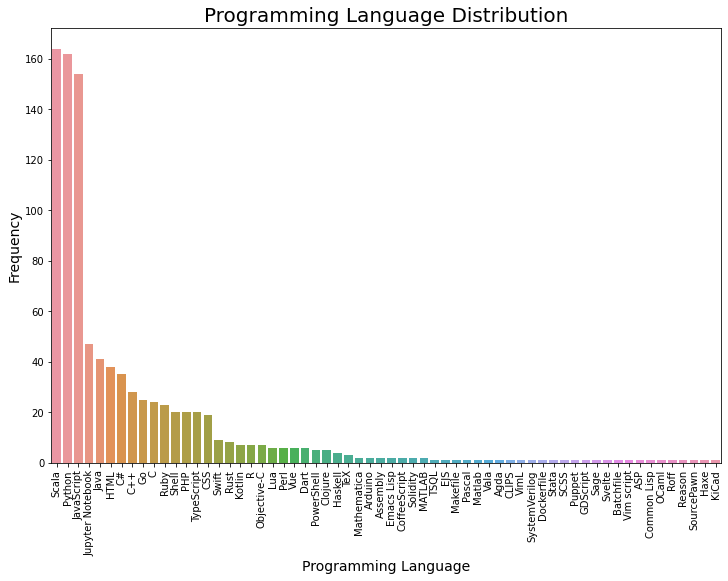

In [10]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="language", data=df,order = df['language'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Programming Language', size = 14)
ax.set_ylabel('Frequency', size = 14)
ax.set_title("Programming Language Distribution", size = 20)
plt.show()

The repos are dominated by three languages: Scala, Python and JavaScript.  There is then an intermediate tier (Java, HTML, the C family) and then a lot of languages as the primary in just 1 or 2 repos.

As such, we will simplify our analysis and modeling to focus on the three main languages, and bucket eveything else together for now.  We will call this our language_group and we can build it in as a feature with our wrangle along with the total word count of the cleaned readmes.

Also, we will add in additional stopwords (the shared word list below - these are words we determined are commong across all repos and not helpful in diferentiating).

In [11]:
shared_word_list = ['cat', 'use', 'image', 'using', 'file', 'run']

In [12]:
X_train, y_train, X_validate, y_validate, X_test, y_test, df, df_repo_and_original = cat_wrangle(extra_words = (shared_word_list))

Removed 60 rows with empty Readmes.
Removed 197 rows with Readmes < 10 words long.
Train = 415 rows (56.0%) | Validate = 179 rows (24.0%) | Test = 149 rows (20.0%)


In [13]:
df.head()

,language,cleaned,cleaned_length,language_group
0,Scala,scala version continuous contributor open libr...,499,Scala
1,Python,nyaav2 build setting project python feature us...,462,Python
2,JavaScript,httpcat build website hosted code older versio...,79,JavaScript
3,Python,repository toy project gain experience buildin...,174,Python
4,Rust,cat1 clone syntax highlighting git feature ins...,1340,Other


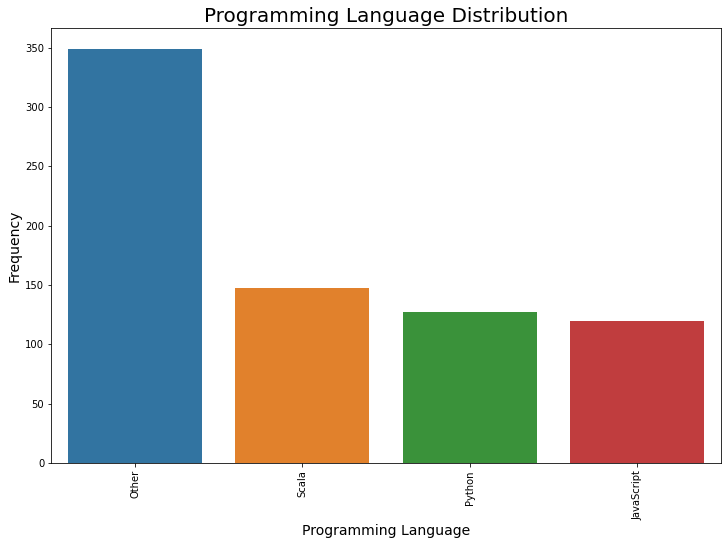

In [14]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="language_group", data=df,order = df['language_group'].value_counts().index)
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Programming Language', size = 14)
ax.set_ylabel('Frequency', size = 14)
ax.set_title("Programming Language Distribution", size = 20)
plt.show()

##### What is the distribution of readme word lengths?

In [15]:
df.cleaned_length.describe()

count     743.000000
mean      181.978466
std       458.609588
min        10.000000
25%        37.000000
50%        88.000000
75%       182.500000
max      9527.000000
Name: cleaned_length, dtype: float64

We initially discovered around 175 readmes that were less than 10 words in length.  While we also have outliers on the other sside (large word legnth readmes) we feel comfrotable leaving those as the TF-IDF normalizes longer string sets while a word count less than 10 likely has no usable information, even if it is weighted more strong vs a longer string.

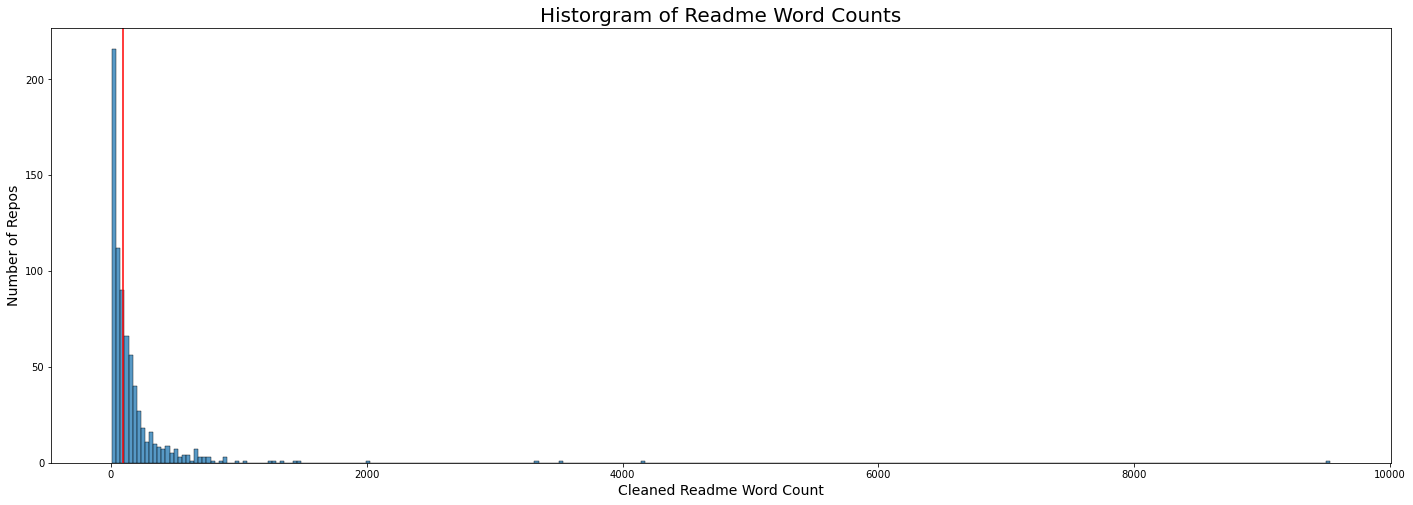

In [16]:
plt.figure(figsize = (24,8))
sns.histplot(x=df.cleaned_length)
plt.xlabel('Cleaned Readme Word Count', size = 14)
plt.ylabel('Number of Repos', size = 14)
plt.title("Historgram of Readme Word Counts", size = 20)
plt.axvline(93, c = 'red')
plt.show()

Zooming in on just those readme's within one standard deviation of the mean, we can see most readmes, at least after cleaning, are fairly short.

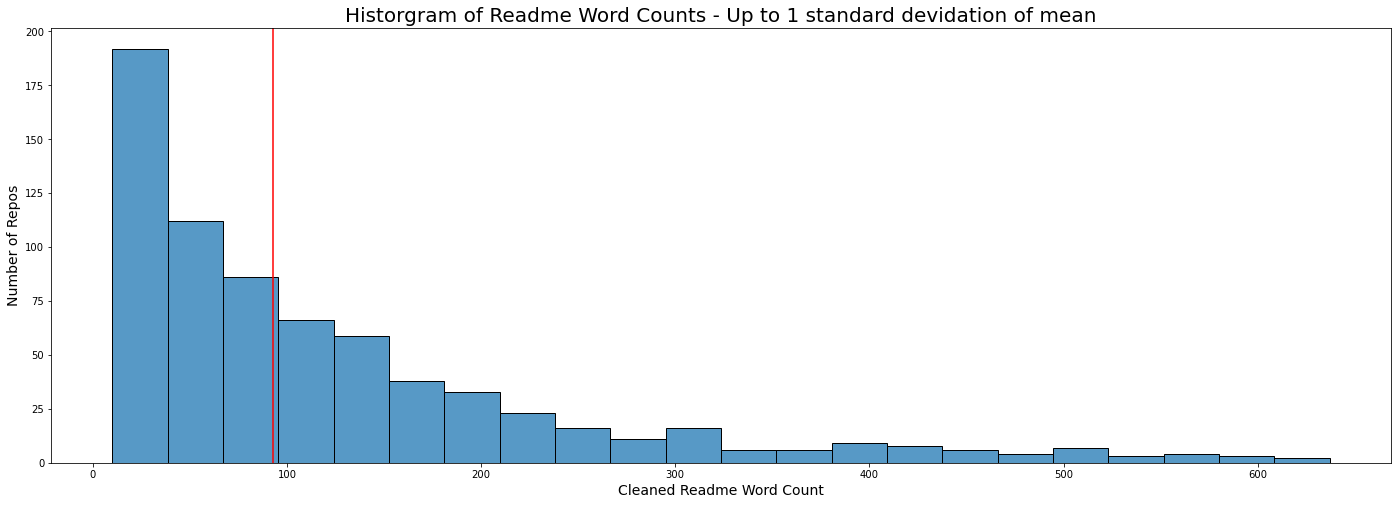

In [17]:
df_removed_high = df[df.cleaned_length < 662]

plt.figure(figsize = (24,8))
sns.histplot(x=df_removed_high.cleaned_length)
plt.xlabel('Cleaned Readme Word Count', size = 14)
plt.ylabel('Number of Repos', size = 14)
plt.title("Historgram of Readme Word Counts - Up to 1 standard devidation of mean", size = 20)
plt.axvline(93, c = 'red')
plt.show()

# $\bigstar$ EDA {RYAN}

In [18]:
# Recombine X_train and y_train into full train dataframe
train = X_train.merge(y_train, left_index = True, right_index = True)

In [19]:
# Set our confidence level
alpha = .05

## Question: Is the word count of cleaned readme indicative of the primary language?

##### Hypothesis Testing (ANOVA comparison of means):

$H_{0}$ = Readmes all have the same mean word count by langauge group.

$H_{1}$ = Readmes do not have the same mean word count by language group.

Assumptions: (X)Independent | (X) Normal (or 30+ obs) | (?) Equal variances?

In [20]:
print(f"Python variances = {train[train['language_group']=='Python'].cleaned_length.var()}")
print(f"Scala variances = {train[train['language_group']=='Scala'].cleaned_length.var()}")
print(f"JavaScript variances = {train[train['language_group']=='JavaScript'].cleaned_length.var()}")
print(f"Other variances = {train[train['language_group']=='Other'].cleaned_length.var()}")

Python variances = 66855.80845070421
Scala variances = 26419.766937669374
JavaScript variances = 78682.58570782452
Other variances = 169188.10663494573


Not the most equal of variances, but I also did not eliminate the high outliers which is appropriate for this.

I will remove all word counts greater than 2 standard deviations above the mean (1102 = 182 + (460 * 2))

In [21]:
train_deoutliered = train[train.cleaned_length < 1102]

In [22]:
python_readmes = train_deoutliered[train_deoutliered['language_group']=='Python'].cleaned_length
scala_readmes = train_deoutliered[train_deoutliered['language_group']=='Scala'].cleaned_length
js_readmes = train_deoutliered[train_deoutliered['language_group']=='JavaScript'].cleaned_length
other_readmes = train_deoutliered[train_deoutliered['language_group']=='Other'].cleaned_length

In [23]:
print(f"Python variances = {python_readmes.var()}")
print(f"Scala variances = {scala_readmes.var()}")
print(f"JavaScript variances = {js_readmes.var()}")
print(f"Other variances = {other_readmes.var()}")

Python variances = 36345.51577152599
Scala variances = 26419.766937669374
JavaScript variances = 26641.361305361297
Other variances = 25583.91230366492


In [24]:
f, p = stats.f_oneway(python_readmes, scala_readmes, js_readmes, other_readmes)
f, p
print('f: ',f,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

f:  2.8837666100853783 p:  0.03557773305857536
is p/2 < alpha?  True


##### Since p/2 is less than alpha we reject the null hypothesis that all the means are the same.  However, it is very close, and we can see this when graphing.

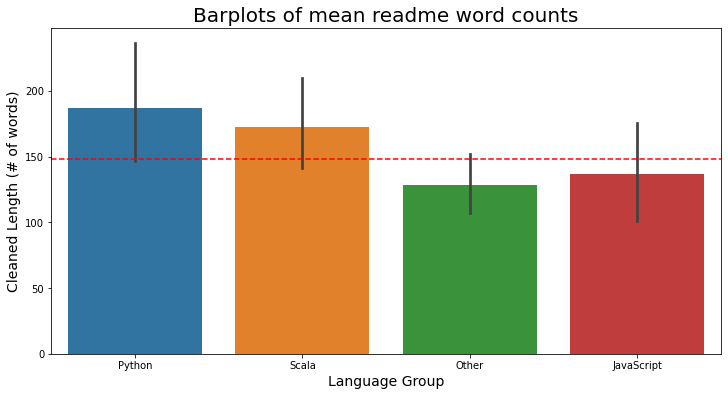

In [25]:
plt.figure(figsize = (12,6))
sns.barplot(data = train_deoutliered, x = 'language_group', y = 'cleaned_length')
plt.xlabel('Language Group', size = 14)
plt.ylabel('Cleaned Length (# of words)', size = 14)
plt.title("Barplots of mean readme word counts", size = 20)
plt.axhline(train_deoutliered.cleaned_length.mean(), c = 'red', linestyle = '--')
plt.show()

> ### Key takeaway: Longer readmes are more likely Python or Scala, but the relationship is not strong enough to be predictive.

## Wordclouds

We also performed a number of qualitative visualizations using single word wordclouds, as well as bigram wordclouds, to see if they could give good information as to the language of the repo.  

We analyze each language_group independently and then cross-compare:

In [26]:
train = X_train.merge(y_train, left_index = True, right_index = True)

In [27]:
train

,language,cleaned,cleaned_length,language_group
196,Python,repository demonstrates train dog recognition ...,200,Python
774,Python,upload client supported operating window minim...,47,Python
249,Scala,manage state management library scalajs follow...,386,Scala
547,Java,ultimate rendering engine inspired reinventing...,55,Other
344,C,version window system xclock program enhanced ...,175,Other
...,...,...,...,...
429,Python,code rajarshi guha oechem family descriptor de...,28,Python
834,Python,dog repository try build classification predic...,507,Python
244,Batchfile,powerful new minecraft server combine forge re...,50,Other
901,JavaScript,improcess comment feedback inter news photo ph...,10,JavaScript


### Python:

(-0.5, 399.5, 199.5, -0.5)

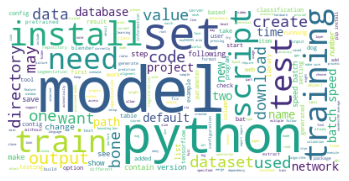

In [28]:
# Create Python only df
python_df = train[train.language_group == 'Python']

# Joining all the readmes together
python_text = ''
for i in range(python_df.shape[0]):
    python_text = python_text + python_df.cleaned.iloc[i]
    
# Building the word cloud
img = WordCloud(background_color='white').generate(python_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

Bigram word cloud:

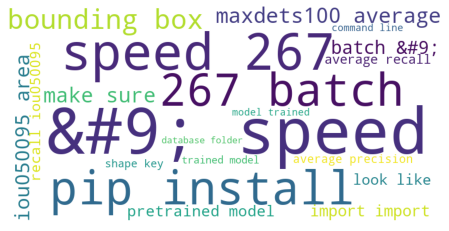

In [29]:
# Create list of top 20 Python bigrams
top_20_python_bigrams = (pd.Series(nltk.ngrams(python_text.split(), 2))
                      .value_counts()
                      .head(20))

data = {k[0] + ' ' + k[1]: v for k, v in top_20_python_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- Python is the top individual word (big surprise) and 'pip install' stands out in the bigrams.

### Scala:

(-0.5, 399.5, 199.5, -0.5)

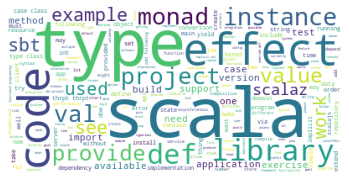

In [30]:
scala_df = train[train.language_group == 'Scala']

scala_text = ''
for i in range(scala_df.shape[0]):
    scala_text = scala_text + scala_df.cleaned.iloc[i]

img = WordCloud(background_color='white').generate(scala_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

Bigram word cloud:

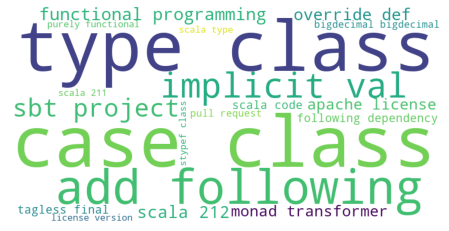

In [31]:
top_20_scala_bigrams = (pd.Series(nltk.ngrams(scala_text.split(), 2))
                      .value_counts()
                      .head(20))

data = {k[0] + ' ' + k[1]: v for k, v in top_20_scala_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- 'Scala' is the type single word, 'effect' seemed a unique word here as well.  Fro bigrams, 'type class' and 'case class' are likely indicators of Scala.

## JavaScript:

(-0.5, 399.5, 199.5, -0.5)

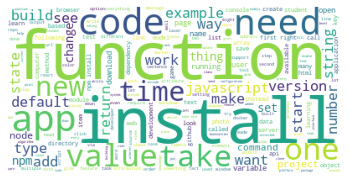

In [32]:
js_df = train[train.language_group == 'JavaScript']

js_text = ''
for i in range(js_df.shape[0]):
    js_text = js_text + js_df.cleaned.iloc[i]
    
img = WordCloud(background_color='white').generate(js_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

Bigram word cloud:

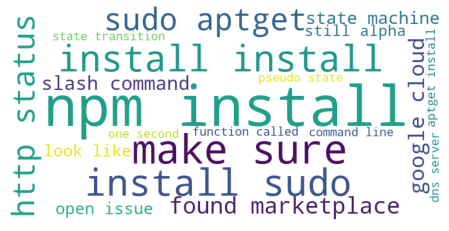

In [33]:
top_20_js_bigrams = (pd.Series(nltk.ngrams(js_text.split(), 2))
                      .value_counts()
                      .head(20))

data = {k[0] + ' ' + k[1]: v for k, v in top_20_js_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- A sure giveaway of a Javascript repo is 'npm install'.

## Other:

(-0.5, 399.5, 199.5, -0.5)

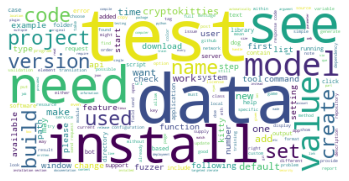

In [34]:
other_df = train[train.language_group == 'Other']

other_text = ''
for i in range(other_df.shape[0]):
    other_text = other_text + other_df.cleaned.iloc[i]
    
img = WordCloud(background_color='white').generate(other_text)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

Bigram word cloud:

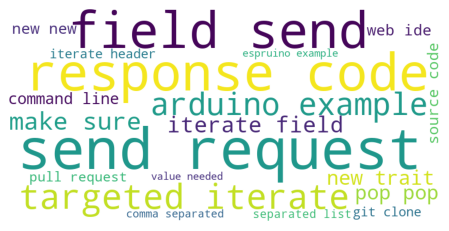

In [35]:
top_20_other_bigrams = (pd.Series(nltk.ngrams(other_text.split(), 2))
                      .value_counts()
                      .head(20))

data = {k[0] + ' ' + k[1]: v for k, v in top_20_other_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

- 'Test', 'targested iterate', and 'reponse code' seem to be indicators of Other, even though Other represents dozens of languages.

#  $\bigstar$ Modeling

#### Finally, we sought to model repos using TF-IDF to engineer the feature which gives special weight to predictive words.  We create this feature using sklearn's TfidfVectorizer.

In [36]:
tfidf = TfidfVectorizer()

## Establishing a Baseline:
- It appears that our baseline model, which would assign the most common language group to all of the repos, would have an accuracy of about 47%.

In [37]:
train.language_group.value_counts()

Other         195
Scala          82
Python         71
JavaScript     67
Name: language_group, dtype: int64

In [38]:
train[train.language_group == 'Other'].shape[0] / train.shape[0]

0.46987951807228917

##### Any model with an accuracy greater than 47.5% beats baseline, and accuracy is our key metric.

## Logistic Regression:

In [39]:
#*****************
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
validate['predicted'] = lm.predict(X_validate)

In-sample data:

In [40]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 84.00%
---
Confusion Matrix
actual      JavaScript  Other  Python  Scala
predicted                                   
JavaScript          36      0       0      0
Other               40    223      28      7
Python               1      0      54      0
Scala                0      0       0     86
---
              precision    recall  f1-score   support

  JavaScript       1.00      0.47      0.64        77
       Other       0.75      1.00      0.86       223
      Python       0.98      0.66      0.79        82
       Scala       1.00      0.92      0.96        93

    accuracy                           0.84       475
   macro avg       0.93      0.76      0.81       475
weighted avg       0.88      0.84      0.83       475



Validation Data:

In [41]:
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted))

Accuracy: 59.66%
---
Confusion Matrix
actual      JavaScript  Other  Python  Scala
predicted                                   
JavaScript           2      1       0      0
Other               17     55      18     12
Python               0      0       2      0
Scala                0      0       0     12
---
              precision    recall  f1-score   support

  JavaScript       0.67      0.11      0.18        19
       Other       0.54      0.98      0.70        56
      Python       1.00      0.10      0.18        20
       Scala       1.00      0.50      0.67        24

    accuracy                           0.60       119
   macro avg       0.80      0.42      0.43       119
weighted avg       0.73      0.60      0.52       119



# Decision Tree:

In [42]:
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

clf = DecisionTreeClassifier(max_depth=17, random_state=123)
clf = clf.fit(X_train, y_train)

train['clf_predicted'] = clf.predict(X_train)
validate['clf_predicted'] = clf.predict(X_validate)

In [43]:
print(classification_report(y_train, train.clf_predicted))

              precision    recall  f1-score   support

  JavaScript       0.98      0.82      0.89        77
       Other       0.85      1.00      0.92       223
      Python       0.97      0.76      0.85        82
       Scala       1.00      0.92      0.96        93

    accuracy                           0.91       475
   macro avg       0.95      0.87      0.91       475
weighted avg       0.92      0.91      0.91       475



In [44]:
print(classification_report(y_validate, validate.clf_predicted))

              precision    recall  f1-score   support

  JavaScript       0.44      0.37      0.40        19
       Other       0.66      0.75      0.70        56
      Python       0.50      0.40      0.44        20
       Scala       0.91      0.88      0.89        24

    accuracy                           0.66       119
   macro avg       0.63      0.60      0.61       119
weighted avg       0.65      0.66      0.65       119



## <span style = 'color:green'>KNN: </span>

In [45]:
y_validate.value_counts()

Other         56
Scala         24
Python        20
JavaScript    19
Name: language_group, dtype: int64

In [46]:
X = tfidf.fit_transform(df.cleaned)
y = df.language_group

train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(train_validate, y_train_validate, test_size=.2, stratify = y_train_validate)

train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))

knn = KNeighborsClassifier(n_neighbors = 19, weights='uniform')
knn.fit(X_train, y_train)

train['knn_predicted'] = knn.predict(X_train)
validate['knn_predicted'] = knn.predict(X_validate)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.73


In [47]:
print('Accuracy of KNN classifier on out-of-sample (validate) set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on out-of-sample (validate) set: 0.71


In [48]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.70


# $\bigstar$ Conclusions

## Key Findings
- Cat related repo programming languages are predominantly Python, Scala and JavaScript, however a total of 62 unique primary programming languages are represented in this repo sample size of 1000
- When cleaned for NLP analysis, most readme's are less than 100 words long.  And in general, the mean length of a repo doesn't very much between the language groups, although technically they are not the same within a 95 condfidence level.
- In addition to the names of the languages themselves, certain key words - and even more so bigrams - are highly indicative of a language, as visualized in a word cloud.  For example, npm is readily found in JavaScript while pip is the equivalent in Pythong.  The strength of words in 'Other' is harder to fee confident about, since there are so mny individual languages that contribute, but "response code" and '"send request" are things to look out for.
- Classification models perform strongly over baseline.

## Model Effectiveness
- Baseline model predicts 'Other' language group for all observations and is therefore accurate 47.5% of the time.
- All Classificaion models performed strongly over baseline, with our strongest KNN model using 19 neighbors accurately predicting language group 65% of the time on out-of-sample-data.

## Recommendations and Next Steps
- We feel there is room from improvement for the models and recommend continuing to refine them and hyperparameter tune.
- After those improvements, I recommend testing this on other 'themes' of repos (maybe ones that come up when searching for 'birds' since they are also up to no good consipracies).
- While we focused purely on primary language only, including other top languages used in the repo (since most repos used multiple langauges) we may be able to further improve accuracy of our predictions.